# 컬러 이미지 데이터셋인 CIFAR-10 을 사용하여 모델 설계 및 성능 확인


In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.1  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

- MNIST 데이터셋과 같은 방식으로, `torchvision`의 `datasets`로부터 CIFAR-10 데이터셋 다운로드
  - `root`: 데이터가 저장될 장소 경로 지정 `../`은 상위폴더 의미
  - `train`: training 데이터셋인지, test 데이터셋인지 설정(True면 training 데이터셋)
  - `download`: 인터넷에서 다운로드해 이용할 것인지 결정하는 요소
  - `transform`: 다운로드할 때 기본적인 전처리 동시에 진행할 수 있음, 여기서는 `transforms.ToTensor()`를 이용하였는데, Tensor 형태로 변환하고, pixel값을 255로 나누어 0~1 사이의 숫자로 정규화하는 과정이 포함되어 있음
    - `transforms.ToTensor()` :  `PIL` 이미지나, numpy.ndarray (H x W x C) in the range [0, 255] 형태로 표현된 이미지를 shape (C x H x W) in the range [0.0, 1.0]의 `torch.FloatTensor`으로 바꿔줌

- `DataLoader`: 다운로드한 dataset을 mini-batch 단위로 분리하여 불러오기 위한 loader
  `shuffle`: 데이터의 순서를 섞고자할 때

In [4]:
''' 3. CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


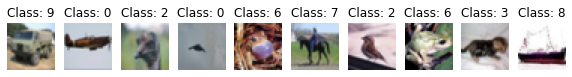

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 6. Multi Layer Perceptron (MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # x = F.log_softmax(x, dim = 1)
        return x 

In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
''' 10. MLP 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.298638
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.773582
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.696451
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.678797
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.745996
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.698080
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.702970
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.796611

[EPOCH: 1], 	Test Loss: 0.0538, 	Test Accuracy: 37.87 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.827377
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.539498
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.680649
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.545369
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.659352
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.525928
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.570536
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.686231

[EPOCH: 2], 	Test Loss: 0.0513, 	Test Accuracy: 41.39 % 